<a href="https://colab.research.google.com/github/BrisGeorge24044/Cognitive_Artificial_Intelligence/blob/main/LeakyRNN_with_Hebbian_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hebbian Learning Rule:
- Neurons that fire together, wire together

    Δw<sub>ij</sub> = η ⋅ x<sub>i</sub> ⋅ y<sub>j</sub>

- w<sub>ij</sub> = Weight which connects the pre- and post-synaptic neurons together
- x<sub>i</sub> = pre-synaptic neuron activity
- y<sub>j</sub> = post-synaptic neuron activity
- η = Learning Rate


In [1]:
!pip install neurogym
!pip install gym==0.25.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 24.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neurogym: filename=neurogym-0.0.2-py3-none-any.whl size=118573 sha256=bb204935d2db488559846c0d94517ff7351be64027401531c3c928cbce93d0fa
  Stored in directory: /root/.cache/pip/wheels/f4/57/a7/66ed4eccf946052534253e4279438b97133b64facca56d4238
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793128 sha256=40d7f1d2d0c899d5741bf01502ff9b320f9d61c591d46bb6097991c4a3b22e71
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built neurogym gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Success

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

LeakyRNN Class defines the Leaky RNN and sets parameters.

In [3]:
class LeakyRNN(nn.Module):
  # Function applies the hebbian learning rule
  def hebbian_learning_rule(self, input, hidden, lr = 0.01):
    batch_size = input.size(0)

    # Add dimension for input and hidden
    input = input.view(batch_size, 1, -1)
    hidden = hidden.view(batch_size, -1, 1)

    # Computes weight change for input to hidden state
    # torch.bmm performs batch multiplication
    # Creates (batch_size, hidden_size, input_size)
    delta_input2hidden = lr * torch.bmm(hidden, input)
    # Computes weight change for hidden to hidden state
    # Creates (batch_size, hidden_size, hidden_size)
    delta_hidden2hidden = lr * torch.bmm(hidden, hidden.transpose(1, 2))

    # Weight changes are added together to update the weight matrices
    delta_input2hidden_sum = delta_input2hidden.sum(dim=0)
    delta_hidden2hidden_sum = delta_hidden2hidden.sum(dim=0)

    # scale factor controls the impact of the learning rule
    hebbian_scale_factor = 1

    # torch.no_grad disables gradient tracking as it is not required for hebbian
    # learning
    with torch.no_grad():
        # Updates the weights using the scale factor and the sum of the
        # weight changes
        self.input2hidden.weight += hebbian_scale_factor * delta_input2hidden_sum
        self.hidden2hidden.weight += hebbian_scale_factor * delta_hidden2hidden_sum
        # torch.norm normalises the weights. Previously there were stability
        # issues which are now avoided. The addition of 1e-6 prevents division
        # by zero.
        self.input2hidden.weight.data = self.input2hidden.weight.data / (torch.norm(self.input2hidden.weight.data) + 1e-6)
        self.hidden2hidden.weight.data = self.hidden2hidden.weight.data / (torch.norm(self.hidden2hidden.weight.data) + 1e-6)

        # Created a check for NaN in weights as this was an issue which was
        # causing instability
    if torch.isnan(self.input2hidden.weight).any() or torch.isnan(self.hidden2hidden.weight).any():
        print("NaN detected in weights!")

  def __init__(self, input_size, hidden_size, dt = None):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.tau = 100
    # Sets alpha as a function of the time step, dt, and the time constant, tau
    if dt is None:
      alpha = 1
    else:
      alpha = dt/self.tau
    self.alpha = alpha
    # Defines linear layers for the input to hidden and hidden to hidden
    # connections
    self.input2hidden = nn.Linear(input_size, hidden_size)
    self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
  # init_hidden function initialises the hidden state as a matrix of zeros
  def init_hidden(self, input_shape):
    batch_size = input_shape[1]
    return torch.zeros(batch_size, self.hidden_size)

  # Recurrence function updates the hidden state
  def recurrence(self, input, hidden):
    self.hebbian_learning_rule(input, hidden)
    # ReLU non-linear activation function is used to calculate the new hidden
    # state using the input and recurrent weight matrices
    h_new = torch.relu(self.input2hidden(input) + self.hidden2hidden(hidden))
    # Leaky integration is applied with alpha deciding how much of the last
    # state is retained
    h_new = hidden * (1 - self.alpha) + h_new * self.alpha
    return h_new

   # Forward function - process the sequence for every time step
  def forward(self, input, hidden = None):
    # If there is no hidden state, then it is initialised here
    if hidden is None:
      hidden = self.init_hidden(input.shape).to(input.device)

      output = []
      # Creates a loop for every time step
      steps = range(input.size(0))
      for i in steps:
        # Updates the hidden state using the recurrence function
        hidden = self.recurrence(input[i], hidden)
        output.append(hidden)

      # Stacks all outputs in one dimension
      output = torch.stack(output, dim = 0)
      return output, hidden

RNNNet Class creates a fully connected layer which converts the hidden states into final predictions.

In [4]:
class RNNNet(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, **kwargs):
    super().__init__()
    # The LeakyRNN class is instantiated
    self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)
    # A fully connected layer is created and applied as the last step of the
    # program to obtain predictions
    self.fc = nn.Linear(hidden_size, output_size)

  # Forward function processes the input through the Leaky RNN and the FC layer
  def forward(self, x):
    rnn_output, _ = self.rnn(x)
    # FC layer is applied to obtain the predictions for every time step
    out = self.fc(rnn_output)
    return out, rnn_output

In [5]:
import neurogym as ngym

# ContextDecisionMaking-v0 task is selected from neurogym
task_name = 'ContextDecisionMaking-v0'
# Time step and stimulus length are defined
kwargs = {'dt': 20, 'timing': {'stimulus': 1500}}

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [6]:
# The sequence length (Num of time steps for each input) and batch size are defined
seq_len = 150
batch_size = 24

# Dataset is created with ngym.Dataset
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
env = dataset.env

# Inputs and targets are taken from the dataset
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

# Input and output size are defined by the neurogym environment
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print(inputs.shape)
print(target.shape)

torch.Size([150, 24, 7])
(150, 24)


/usr/local/lib/python3.10/dist-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
# Defines the hidden size
hidden_size = 192

# RNNNet is instantiated
net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
print(net)

# This function trains the model using the Hebbian Learning Rule
def train_model_hebbian(net, dataset):
  # Defines the loss function
  criterion = nn.CrossEntropyLoss()

  # Tracks the loss and time
  running_loss = 0
  start_time = time.time()
  # Creates a loop for the number of iterationa
  for i in range(300):
      # Takes inputs and labels from the dataset
      inputs, labels = dataset()
      inputs = torch.from_numpy(inputs).type(torch.float)
      labels = torch.from_numpy(labels.flatten()).type(torch.long)

      # Creates a forward pass
      output, _ = net(inputs)
      # Tensor is flattened to 2D
      output = output.view(-1, output_size)
      # Loss is calcualated using the loss function
      loss = criterion(output, labels)

      # This tracks the loss from the loss at each iteration
      running_loss += loss.item()
      # If statement to calculate and print an average loss every 100
      # iterations
      if (i+1) % 10 == 0:
          running_loss /= 10
          print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
              i+1, running_loss, time.time() - start_time))
          running_loss = 0

  return net


net = train_model_hebbian(net, dataset)

RNNNet(
  (rnn): LeakyRNN(
    (input2hidden): Linear(in_features=7, out_features=192, bias=True)
    (hidden2hidden): Linear(in_features=192, out_features=192, bias=True)
  )
  (fc): Linear(in_features=192, out_features=3, bias=True)
)
Step 10, Loss 1.8574, Time 3.9s
Step 20, Loss 1.8689, Time 8.5s
Step 30, Loss 1.8714, Time 11.9s
Step 40, Loss 1.8686, Time 15.6s
Step 50, Loss 1.8705, Time 21.9s
Step 60, Loss 1.8712, Time 27.8s
Step 70, Loss 1.8680, Time 33.7s
Step 80, Loss 1.8723, Time 39.3s
Step 90, Loss 1.8721, Time 44.9s
Step 100, Loss 1.8711, Time 49.9s
Step 110, Loss 1.8698, Time 55.4s
Step 120, Loss 1.8720, Time 60.9s
Step 130, Loss 1.8722, Time 66.7s
Step 140, Loss 1.8711, Time 73.7s
Step 150, Loss 1.8708, Time 80.8s
Step 160, Loss 1.8708, Time 86.9s
Step 170, Loss 1.8683, Time 90.5s
Step 180, Loss 1.8737, Time 97.6s
Step 190, Loss 1.8716, Time 102.8s
Step 200, Loss 1.8712, Time 107.6s
Step 210, Loss 1.8723, Time 115.4s
Step 220, Loss 1.8722, Time 123.7s
Step 230, Loss 1.8709,

Testing Phase:

In [8]:
# Environment is reset after training
env = dataset.env
env.reset(no_step=True)

# Performance is tracked
perf = 0
# Dictionaries to store activity and information for each trial are created
activity_dict = {}
trial_infos = {}

# Number of trials is set to 200
num_trial = 200

# For loop is created to run the model for 200 trials
for i in range(num_trial):
  # Starts a trial
  trial_info = env.new_trial()
  # defines the observations and ground truths for each trial
  ob, gt = env.ob, env.gt
  # Converts observations to batch dimensions
  inputs = torch.from_numpy(ob[:,np.newaxis, :]).type(torch.float)

  # Takes the predictions from the model
  action_pred, rnn_activity = net(inputs)

  # Converts the predictions to a numpy array and selects the action predicted
  # by the model (the largest value)
  action_pred = action_pred.detach().numpy()[:, 0, :]
  choice = np.argmax(action_pred[-1, :])
  correct = choice == gt[-1]

  # Stores the activity and trial info in dictionaries
  rnn_activity = rnn_activity[:, 0, :].detach().numpy()
  activity_dict[i] = rnn_activity
  trial_infos[i] = trial_info
  trial_infos[i].update({'choice': choice, 'correct': correct})

  # Tracks the performance
  if correct:
    perf += 1

for i in range(20):
  print('Trial', i + 1, trial_infos[i])

print(f"Average performance = {np.mean([val['correct'] for val in trial_infos.values()])}")
print(f"Performance: {perf}/{num_trial}")

Trial 1 {'ground_truth': 2, 'other_choice': 2, 'context': 1, 'coh_0': 5, 'coh_1': 50, 'choice': 2, 'correct': True}
Trial 2 {'ground_truth': 2, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 5, 'choice': 2, 'correct': True}
Trial 3 {'ground_truth': 1, 'other_choice': 2, 'context': 1, 'coh_0': 5, 'coh_1': 50, 'choice': 2, 'correct': False}
Trial 4 {'ground_truth': 2, 'other_choice': 1, 'context': 1, 'coh_0': 15, 'coh_1': 15, 'choice': 2, 'correct': True}
Trial 5 {'ground_truth': 2, 'other_choice': 2, 'context': 0, 'coh_0': 15, 'coh_1': 50, 'choice': 2, 'correct': True}
Trial 6 {'ground_truth': 1, 'other_choice': 1, 'context': 1, 'coh_0': 15, 'coh_1': 15, 'choice': 2, 'correct': False}
Trial 7 {'ground_truth': 2, 'other_choice': 2, 'context': 0, 'coh_0': 15, 'coh_1': 15, 'choice': 2, 'correct': True}
Trial 8 {'ground_truth': 2, 'other_choice': 2, 'context': 1, 'coh_0': 15, 'coh_1': 5, 'choice': 2, 'correct': True}
Trial 9 {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_

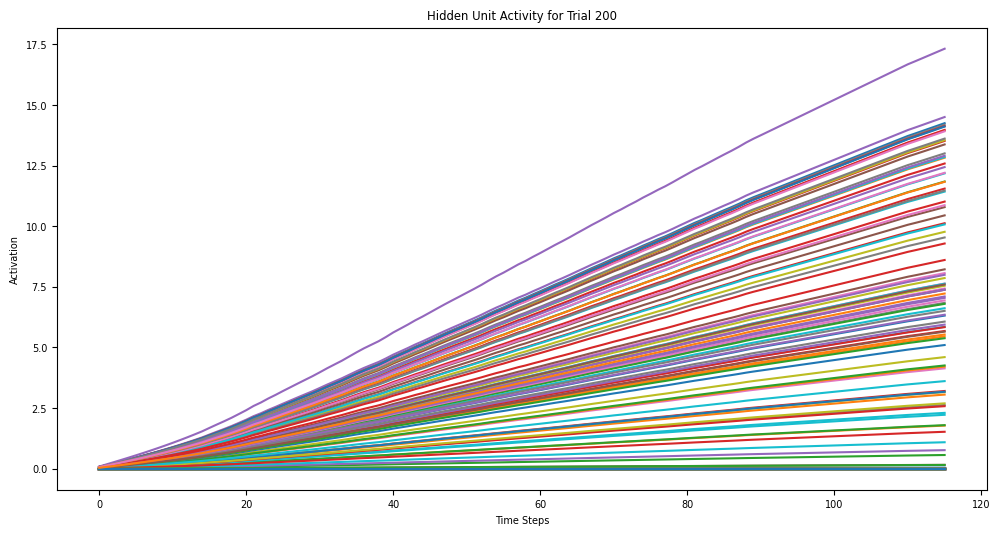

In [9]:
trial_number = 199  # Select a specific trial to visualize
rnn_activity = activity_dict[trial_number]  # Get the activity for the selected trial

plt.figure(figsize=(12, 6))
for i in range(rnn_activity.shape[1]):  # Plot each hidden unit's activity
    plt.plot(rnn_activity[:, i])
plt.xlabel('Time Steps')
plt.ylabel('Activation')
plt.title(f'Hidden Unit Activity for Trial {trial_number + 1}')
plt.show()